## Overview 
As part of exploratory data analysis, it is often helpful to see if there are
meaningful subgroups (or *clusters*) in the data; this grouping can be used 
for many purposes, such as generating new questions or improving predictive analyses. 
This chapter provides an introduction to clustering using the *K-means* algorithm,
including techniques to choose the number of clusters.

## Chapter learning objectives 
By the end of the chapter,

* Describe a case where clustering is appropriate, and what insight it might extract from the data.
* Explain the K-means clustering algorithm.
* Interpret the output of a K-means analysis.
* Identify when it is necessary to scale variables before clustering, and do this using R.
* Perform K-means clustering in R using `kmeans`.
* Use the elbow method to choose the number of clusters for K-means.
* Visualize the output of K-means clustering in R using coloured scatter plots.
* Describe the advantages, limitations and assumptions of the K-means clustering algorithm.

## Clustering
Clustering is a data analysis task involving separating a data set into
subgroups of related data. For example, we might use clustering to separate a
data set of documents into groups that correspond to topics, a data set of human
genetic information into groups that correspond to ancestral subpopulations, or
a data set of online customers into groups that correspond to purchasing
behaviours.  Once the data are separated we can, for example, use the subgroups
to generate new questions about the data and follow up with a predictive
modelling exercise. In this course, clustering will be used only for exploratory
analysis, i.e., uncovering patterns in the data that we have.

Note that clustering is a fundamentally different kind of task than
classification or regression. Most notably, both classification and regression
are *supervised tasks* where there is a *predictive target* (a class label or
value), and we have examples of past data with labels/values that help us
predict those of future data. By contrast, clustering is an *unsupervised
task*, as we are trying to understand and examine the structure of data without
any labels to help us. This approach has both advantages and disadvantages.
Clustering requires no additional annotation or input on the data; for example,
it would be nearly impossible to annotate all the articles on Wikipedia with
human-made topic labels, but we can still cluster the articles without this
information to automatically find groupings corresponding to topics. 

However, because there is no predictive target, it is not as easy to evaluate
the "quality" of a clustering.  With classification, we are able to use a test
data set to assess prediction performance. In clustering, there is not a single
good choice for evaluation. In this book, we will use visualization to ascertain
the quality of a clustering, and leave rigorous evaluation for more advanced
courses.  

> There are also so-called *semisupervised* tasks, where only some of the data
> come with labels / annotations, but the vast majority don't. The goal
> is to try to uncover underlying structure in the data that allows one to
> guess the missing labels. This sort of task is very useful, for example, when one 
> has an unlabelled data set that is too large to manually label, but one is willing to
> provide a few informative example labels as a "seed" to guess the labels for all the data.

**An illustrative example** 

Here we will present an illustrative example using a simulated data set. Suppose 
we have data with two variables measuring customer loyalty and 
satisfaction, and we want to learn whether there are distinct "types"
of customer. Understanding this might help us come up with better products or
promotions to improve our business in a data-driven way.

In [2]:
options(warn = -1)

In [3]:
library(tidyverse)
data <- read_csv('marketing.csv') %>%
	 mutate(cluster=as_factor(cluster))
marketing_data <- data[,1:2]

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  loyalty = col_double(),
  csat = col_double(),
  cluster = col_double()
)



In [4]:
marketing_data


loyalty,csat
7.0,1.00
7.5,1.00
8.0,2.00
7.0,2.00
8.0,3.00
1.5,1.75
1.0,3.00
0.5,4.00
2.0,4.00
7.0,6.00


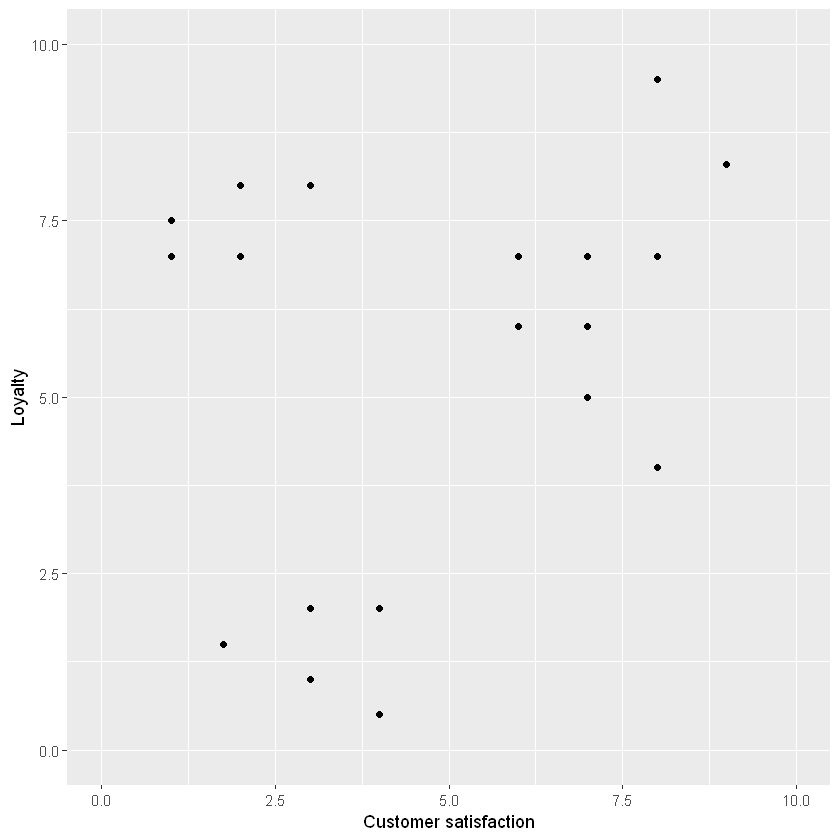

In [5]:
base <- ggplot(data, aes(y = loyalty, x = csat)) +
  geom_point() +
  xlab("Customer satisfaction") +
  ylab("Loyalty") +
  xlim(c(0, 10)) +
  ylim(c(0, 10))
base

Based on this visualization, we might suspect there are a few subtypes of customer,
selected from combinations of high/low satisfaction and high/low loyalty. How
do we find this grouping automatically, and how do we pick the number of subtypes
to look for? The
way to rigorously separate the data into groups is to use a clustering algorithm.
In this chapter, we will focus on the *K-means* algorithm, a widely-used
and often very effective clustering method, combined with the *elbow method* for
selecting the number of clusters. This procedure will separate the data into 
the following groups denoted by colour:

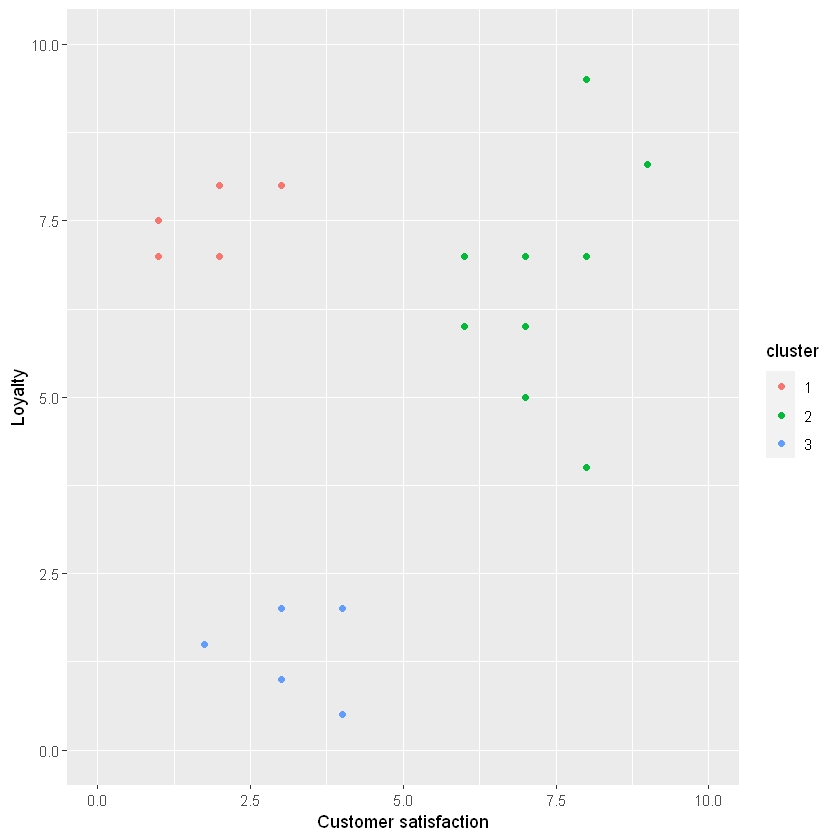

In [6]:
ggplot(data, aes(y = loyalty, x = csat, color = cluster)) +
  geom_point() +
  xlab("Customer satisfaction") +
  ylab("Loyalty") +
  xlim(c(0, 10)) +
  ylim(c(0, 10))

What are the labels for these groups? Unfortunately, we don't have any. K-means,
like almost all clustering algorithms, just outputs meaningless "cluster labels"
that are typically whole numbers: 1, 2, 3, etc. But in a simple case like this,
where we can easily visualize the clusters on a scatter plot, we can give
human-made labels to the groups using their positions on
the plot:

- low loyalty and low satisfaction (<font color="#619CFF">blue cluster</font>),
- high loyalty and low satisfaction (<font color="#F8766D">pink cluster</font>), 
- and high loyalty and high satisfaction (<font color="#00BA38">green cluster</font>).

Once we have made these determinations, we can use them to inform our future business decisions,
or to ask further questions about our data. For example, here we might notice based on our clustering
that there aren't any customers with high satisfaction but low loyalty, and generate new analyses
or business strategies based on this information. 

## K-means 

### Measuring cluster quality


In [7]:
library(tidyverse)
#clus1 <- tibble(loyalty = c(7, 7.5, 8, 7, 8),
#               csat = c(1, 1, 2, 2, 3),
#               )
clus1 <- head(marketing_data, 5)
#clus1_center <- clus1 %>% summarize(csat = mean(csat), loyalty = mean(loyalty))

The K-means algorithm is a procedure that groups data into K clusters.
It starts with an initial clustering of the data, and then iteratively
improves it by making adjustments to the assignment of data
to clusters until it cannot improve any further. But how do we measure
the "quality" of a clustering, and what does it mean to improve it? 
In K-means clustering, we measure the quality of a cluster by its
*within-cluster sum-of-squared-distances* (WSSD). Computing this involves two steps.
First, we find the cluster centers by computing the mean of each variable 
over data points in the cluster. For example, suppose we have a 
cluster containing 3 observations, and we are using two variables, $x$ and $y$, to cluster the data.
Then we would compute the $x$ and $y$ variables, $\mu_x$ and $\mu_y$, of the cluster center via

$$\mu_x = \frac{1}{3}(x_1+x_2+x_3) \quad \mu_y = \frac{1}{3}(y_1+y_2+y_3).$$

In the first cluster from the customer satisfaction/loyalty example, there 
are 5 data points. These are shown with their cluster center 
(`csat = 1.8` and `loyalty = 7.5`) highlighted below.

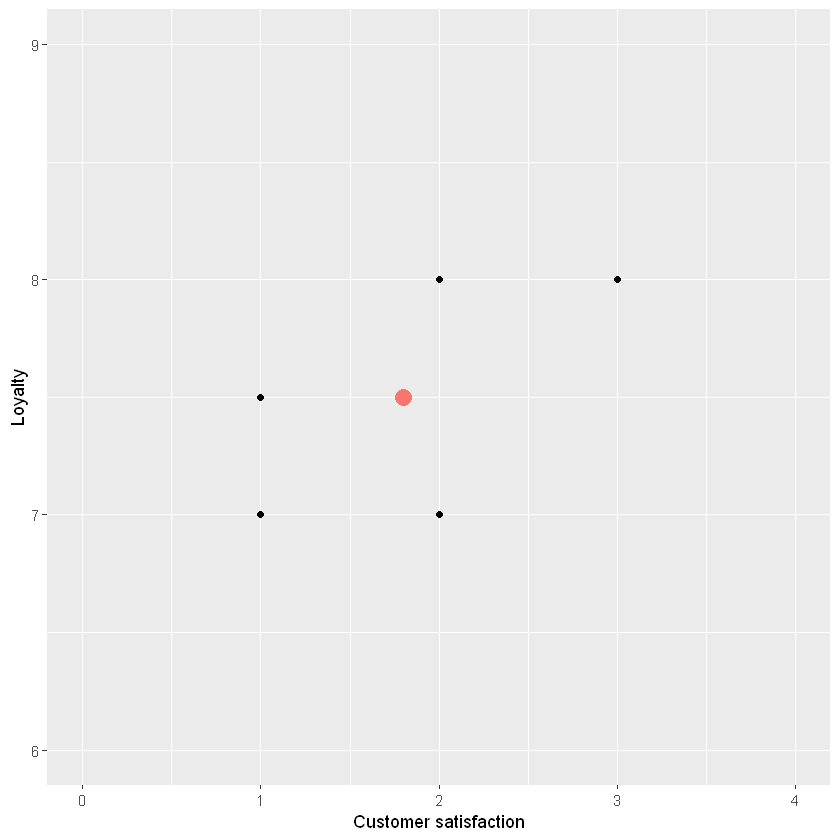

In [8]:
base <- ggplot(clus1) +
  geom_point(aes(y = loyalty, x = csat)) +
  labs(x = "Customer satisfaction", y = "Loyalty") +
  xlim(c(0, 4)) +
  ylim(c(6, 9)) +
  geom_point(aes(y = mean(loyalty), x = mean(csat), colour="red", size=2.5)) +
  theme(legend.position = "none")
base

The second step in computing the WSSD is to add up the squared distance between each point in the cluster and the cluster center.
We use the straight-line / Euclidean distance formula that we learned about in the classification chapter.
In the 3-observation cluster example above, we would compute the WSSD $S^2$ via

$$S^2 = \left((x_1 - \mu_x)^2 + (y_1 - \mu_y)^2\right) + \left((x_2 - \mu_x)^2 + (y_2 - \mu_y)^2\right) +\left((x_3 - \mu_x)^2 + (y_3 - \mu_y)^2\right).$$

These distances are denoted by lines for the first cluster of the customer satisfaction/loyalty data example below. 

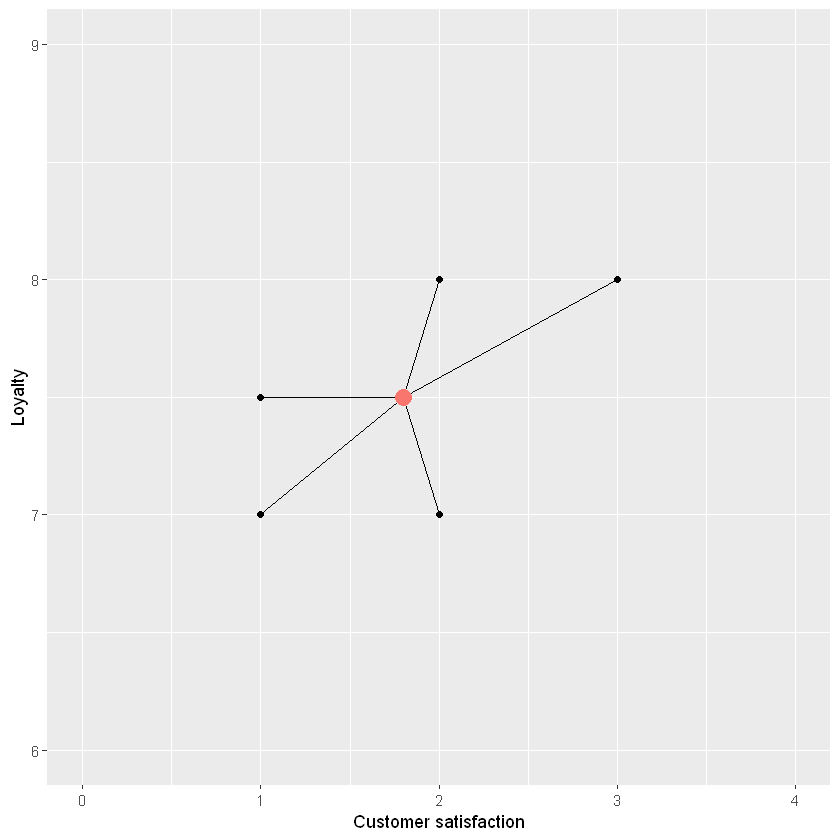

In [9]:
base <- ggplot(clus1) +
  geom_point(aes(y = loyalty, x = csat)) +
  labs(x = "Customer satisfaction", y = "Loyalty") +
  xlim(c(0, 4)) +
  ylim(c(6, 9)) +
  theme(legend.position = "none")
mn <- clus1 %>% summarize(csat = mean(csat), loyalty=mean(loyalty))
for (i in 1:5) {
  base <- base + geom_segment(x = unlist(mn[1, "csat"]), y = unlist(mn[1, "loyalty"]),
                           xend = unlist(clus1[i, "csat"]), yend = unlist(clus1[i, "loyalty"]))
}
base <- base + geom_point(aes(y = mean(loyalty), x = mean(csat), colour="red", size=2.5)) 
base

The larger the value of $S^2$, the more spread-out the cluster is, since large $S^2$ means that points are far away from the cluster center.
Note, however, that "large" is relative to *both* the scale of the variables for clustering *and* the number of points in the cluster; a 
cluster where points are very close to the center might still have a large $S^2$ if there are many data points in the cluster. 

### The clustering algorithm

The K-means algorithm is quite simple. We begin by picking K, and uniformly randomly assigning data to the K clusters. 
Then K-means consists of two major steps that attempt to minimize the
sum of WSSDs over all the clusters, i.e. the *total WSSD*:

1. **Center update:** Compute the center of each cluster.
2. **Label update:** Reassign each data point to the cluster with the nearest center.

These two steps are repeated until the cluster assignments no longer change.
For example, in the customer data example from earlier, our initialization might look like this:


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



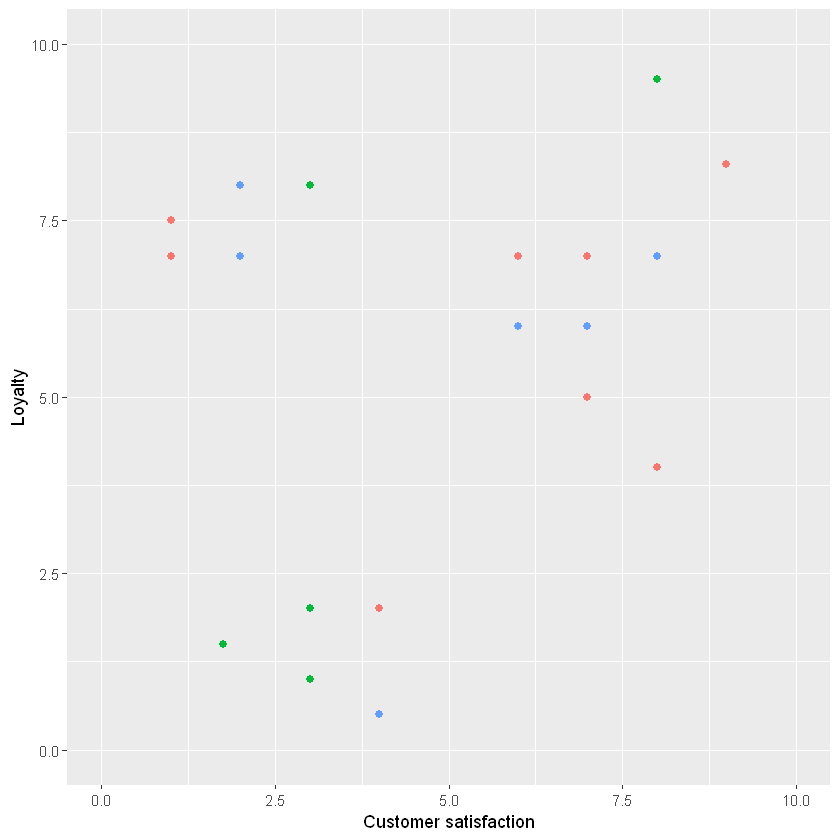

In [10]:
library(gridExtra)
set.seed(14)
marketing_data["label"] = factor(sample(1:3, nrow(marketing_data), replace=T))
plt_lbl <- ggplot(marketing_data, aes(y = loyalty, x = csat, colour=label)) +
    geom_point(size=2) +
    xlab("Customer satisfaction") +
    ylab("Loyalty") +
    xlim(c(0, 10)) +
    ylim(c(0, 10)) + 
    theme(legend.position = "none")
print(plt_lbl)

And the first four iterations of K-means would look like (each row corresponds to an iteration,
where the left column depicts the center update, 
and the right column depicts the reassignment of data to clusters): 

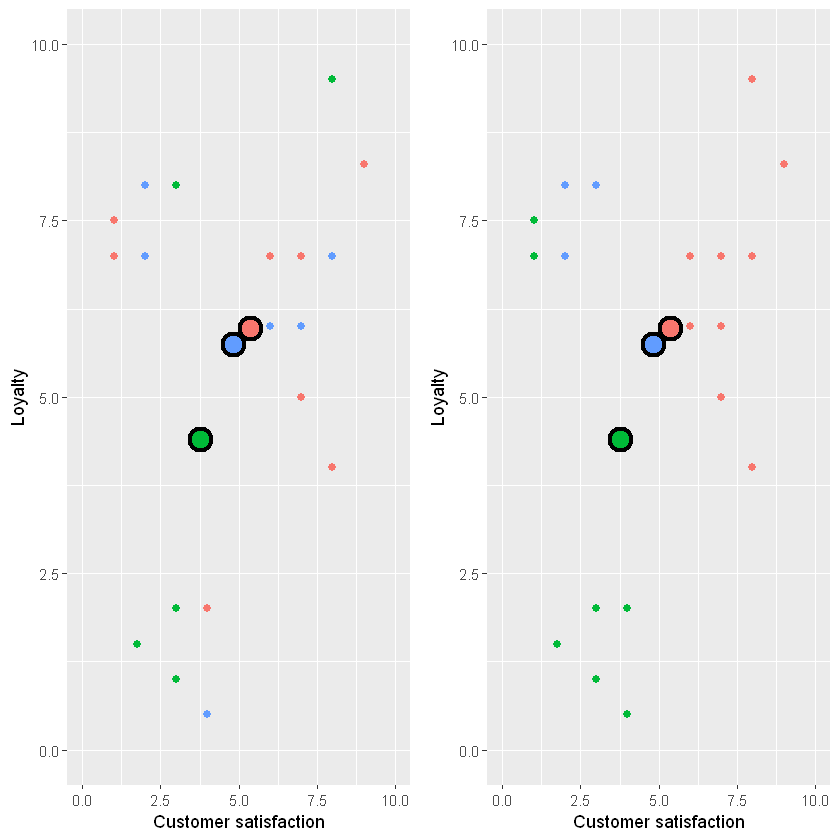

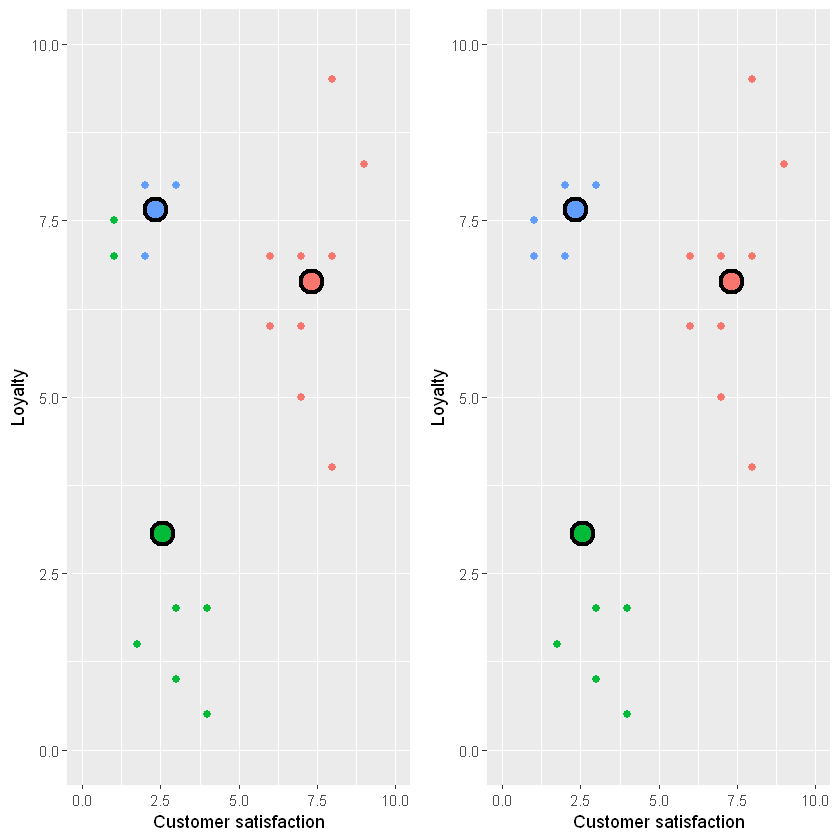

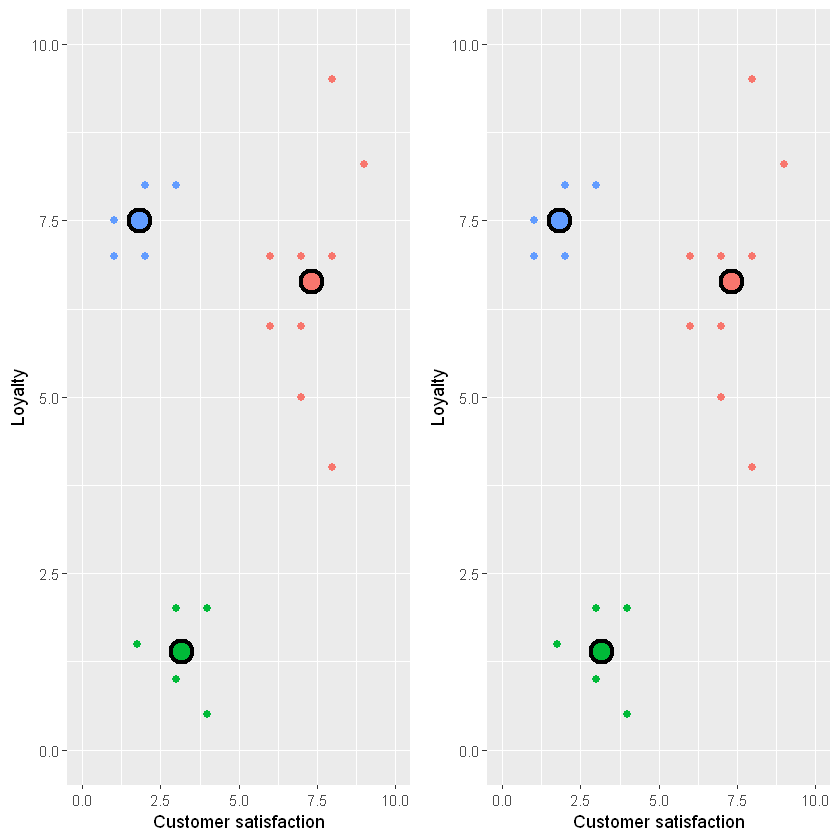

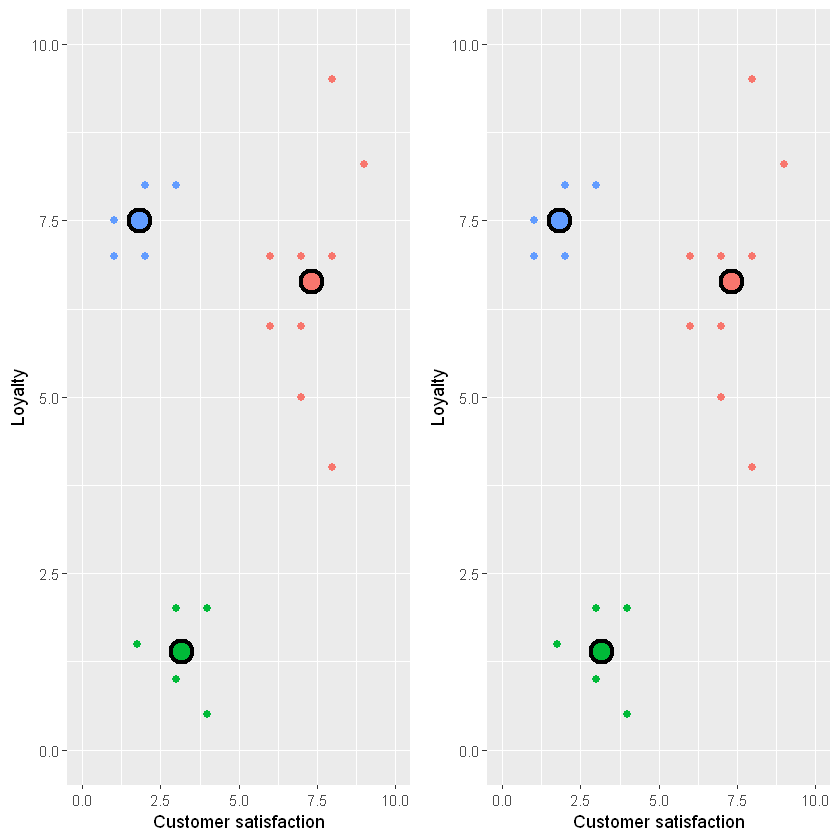

In [12]:
for (i in 1:4){
    #compute centers
    centers <- marketing_data %>% group_by(label) %>% summarize_all(funs(mean))
    nclus = nrow(centers)
    #replot with centers
    plt_ctr <- ggplot(marketing_data, aes(y = loyalty, x = csat, colour=label)) +
        geom_point(size=2) +
        xlab("Customer satisfaction") +
        ylab("Loyalty") +
        xlim(c(0, 10)) +
        ylim(c(0, 10)) + 
        theme(legend.position = "none") +
        geom_point(data = centers, aes(y = loyalty, x = csat, fill = label), size=5, shape = 21, stroke = 2, colour = "black") 
    
    #reassign labels
    dists <- rbind(centers, marketing_data) %>% 
           select("csat", "loyalty") %>%
           dist() %>%
           as.matrix()
    dists <- as_tibble(dists[-(1:nclus),1:nclus])
    marketing_data <- marketing_data %>% mutate(label = apply(dists, 1, function(x) names(x)[which.min(x)]))
    
    plt_lbl <- ggplot(marketing_data, aes(y = loyalty, x = csat, colour=label)) +
        geom_point(size = 2) +
        xlab("Customer satisfaction") +
        ylab("Loyalty") +
        xlim(c(0, 10)) +
        ylim(c(0, 10)) + 
        theme(legend.position = "none") +
        geom_point(data = centers, aes(y = loyalty, x = csat, fill = label), size=5, shape = 21, stroke = 2, colour = "black") 
    
    #to generate the animated version, get rid of grid.arrange and use the below two lines
    #set the figure width to 4.35 too
    #print(plt_ctr)
    #print(plt_lbl)
    grid.arrange(plt_ctr, plt_lbl, nrow = 1)
}

Note that at this point we can terminate the algorithm, since none of the assignments changed
in the fourth iteration; both the centers and labels will remain the same from this point onward.

> Is K-means *guaranteed* to stop at some point, or could it iterate forever? As it turns out,
> the answer is thankfully that K-means is guaranteed to stop after *some* number of iterations. For the interested reader, the
> logic for this has three steps: (1) both the label update and the center update decrease total WSSD in each iteration,
> (2) the total WSSD is always greater than or equal to 0, and (3) there are only a finite number of possible
> ways to assign the data to clusters. So at some point, the total WSSD must stop decreasing, which means none of the assignments
> are changing and the algorithm terminates.
### Random restarts

K-means, unlike the classification and regression models we studied in previous chapters, can get "stuck" in a bad solution.
For example, if we were unlucky and initialized K-means with the following labels:

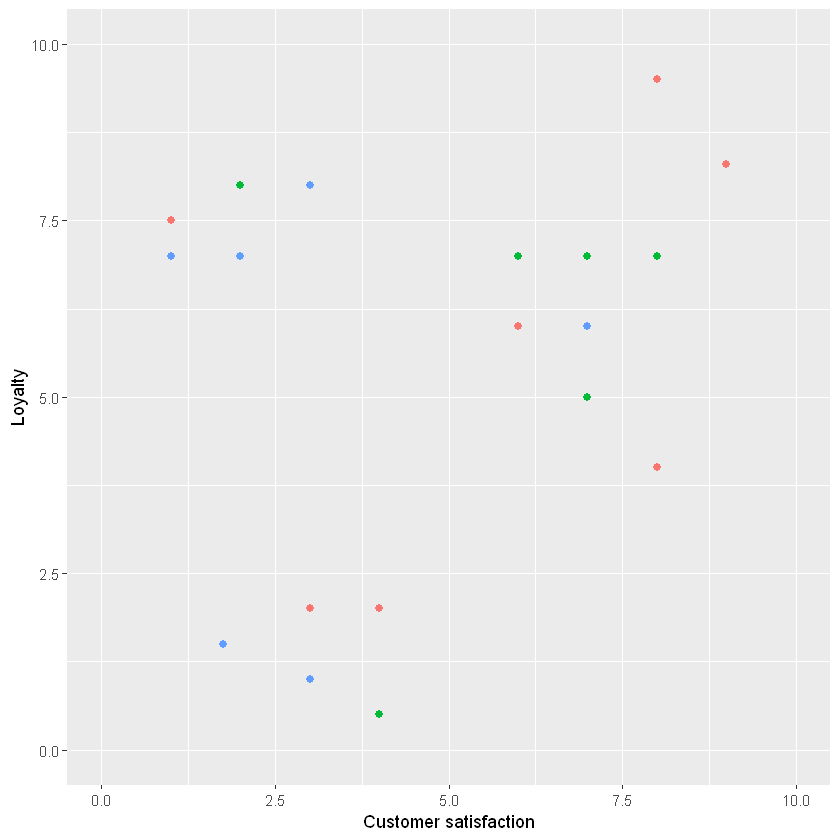

In [13]:
set.seed(9)
marketing_data["label"] = factor(sample(1:3, nrow(marketing_data), replace=T))
plt_lbl <- ggplot(marketing_data, aes(y = loyalty, x = csat, colour=label)) +
    geom_point(size = 2) +
    xlab("Customer satisfaction") +
    ylab("Loyalty") +
    xlim(c(0, 10)) +
    ylim(c(0, 10)) + 
    theme(legend.position = "none")
print(plt_lbl)

Then the iterations of K-means would look like:


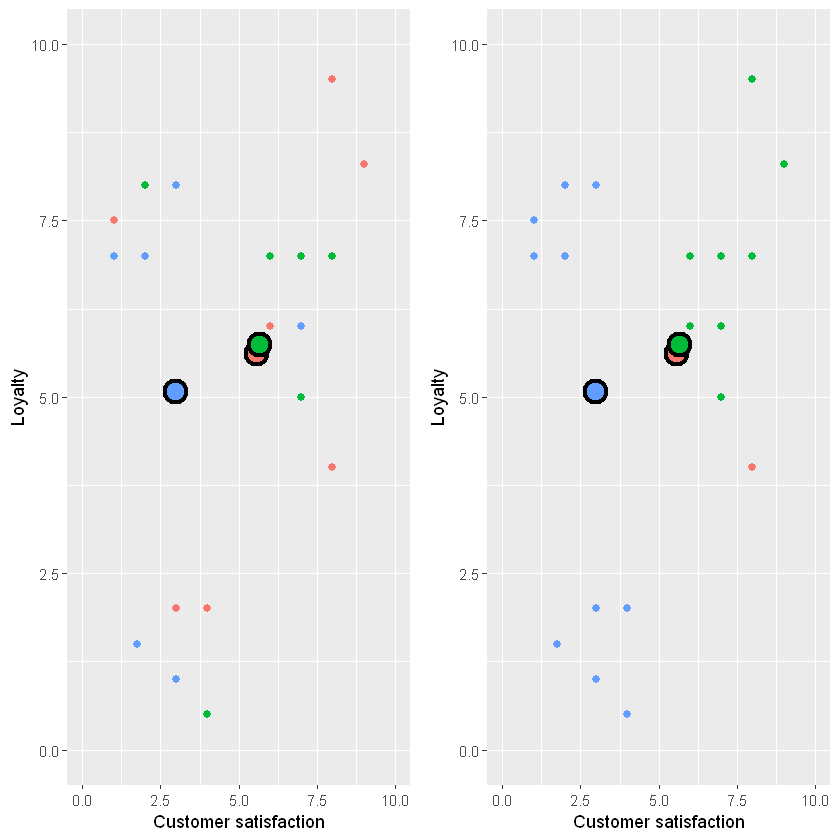

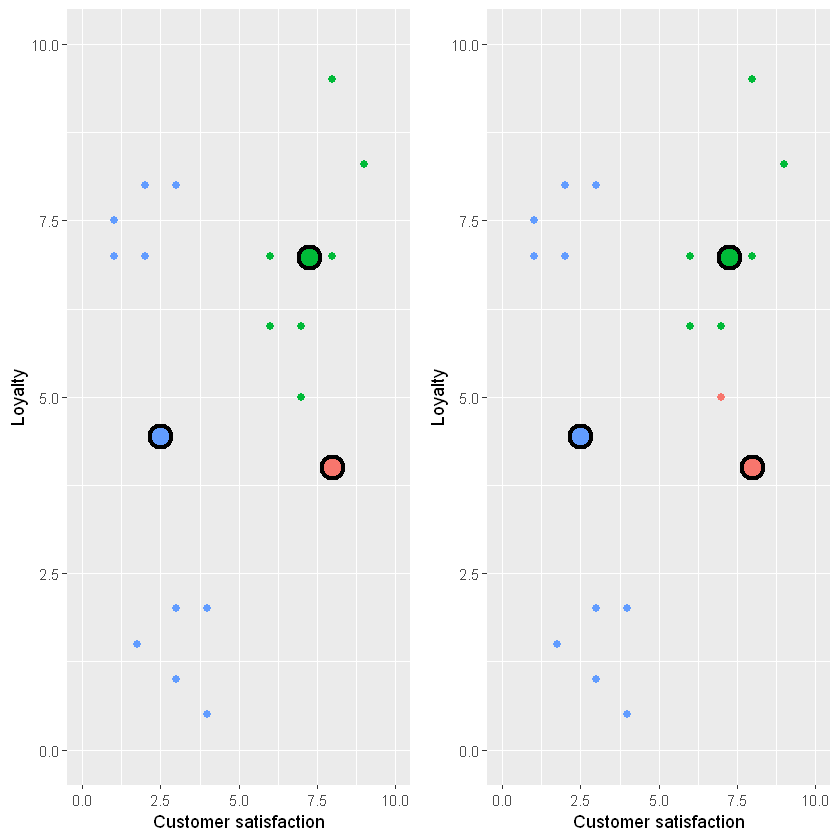

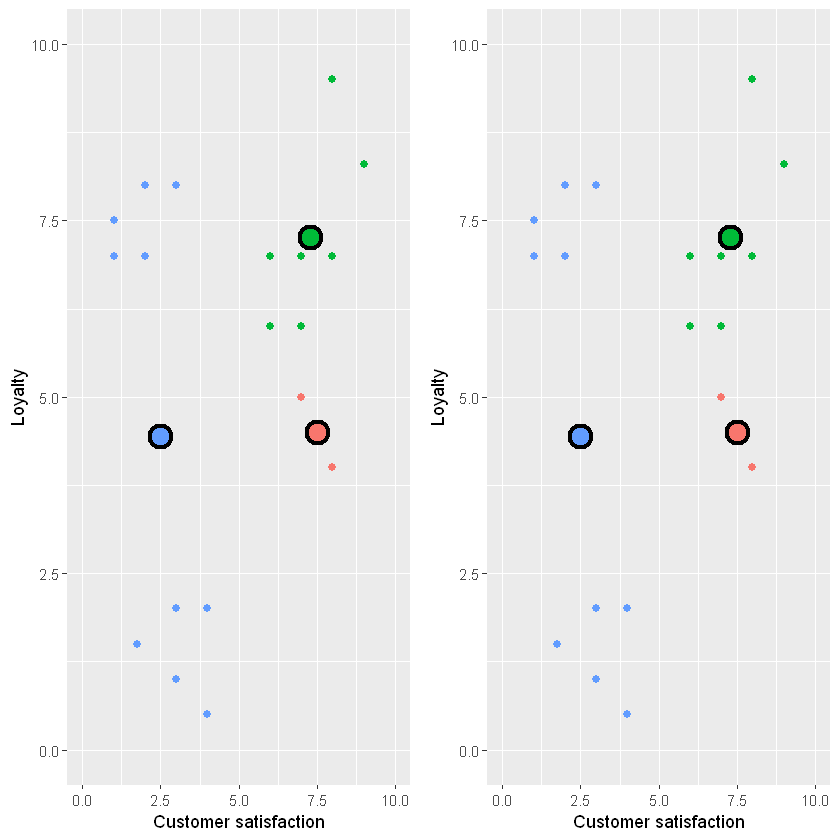

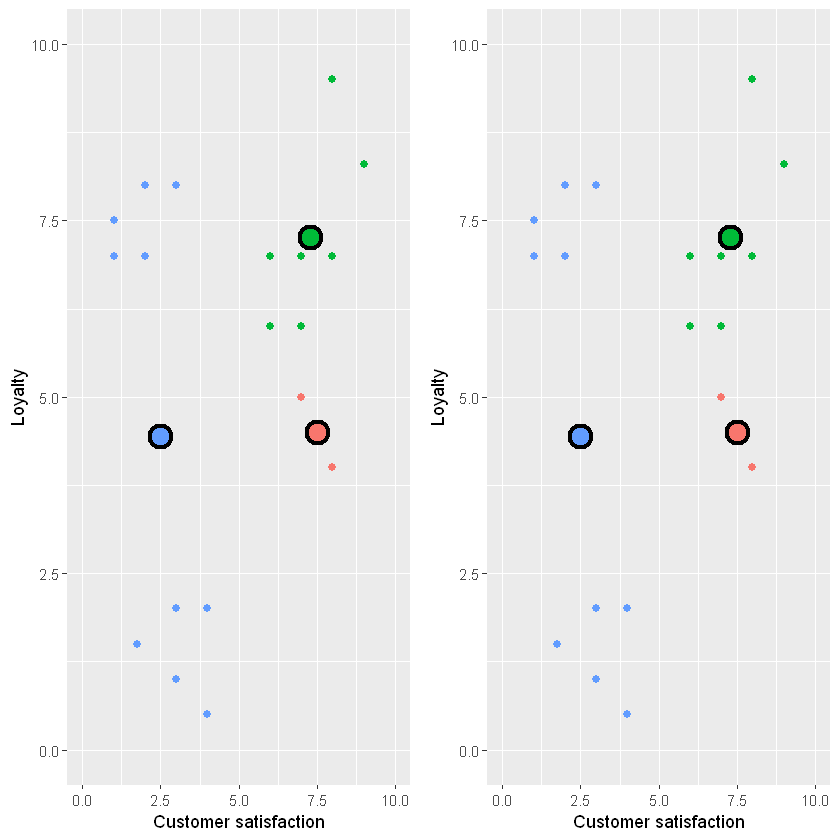

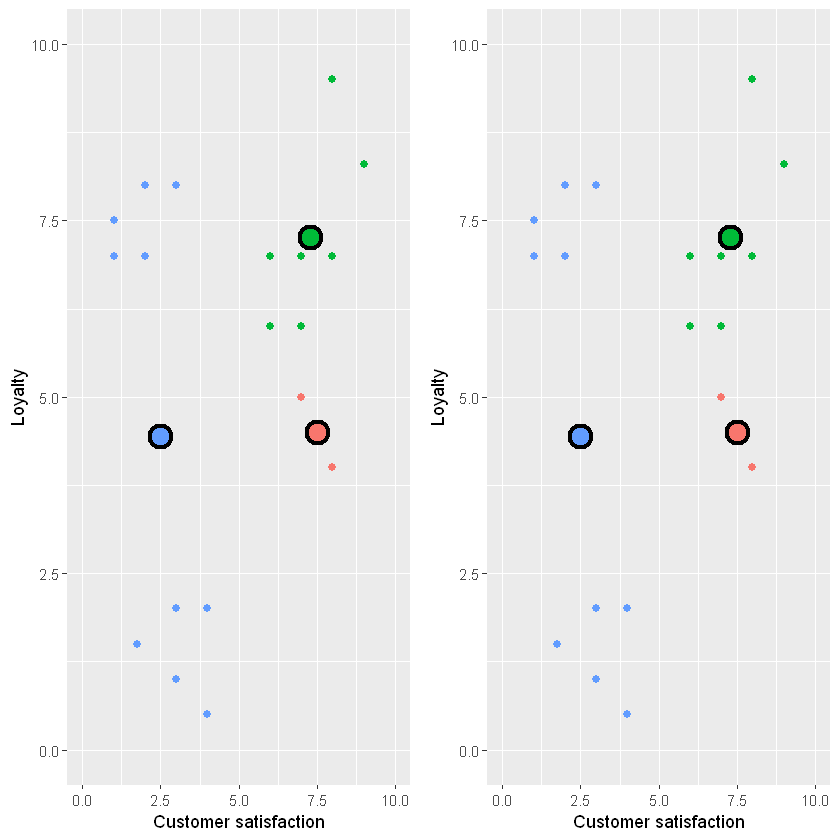

In [14]:
for (i in 1:5){
    #compute centers
    centers <- marketing_data %>% group_by(label) %>% summarize_all(funs(mean))
    nclus = nrow(centers)
    #replot with centers
    plt_ctr <- ggplot(marketing_data, aes(y = loyalty, x = csat, colour=label)) +
        geom_point(size = 2) +
        xlab("Customer satisfaction") +
        ylab("Loyalty") +
        xlim(c(0, 10)) +
        ylim(c(0, 10)) + 
        theme(legend.position = "none") +
        geom_point(data = centers, aes(y = loyalty, x = csat, fill = label), size=5, shape = 21, stroke = 2, colour = "black") 
    
    #reassign labels
    dists <- rbind(centers, marketing_data) %>% 
           select("csat", "loyalty") %>%
           dist() %>%
           as.matrix()
    dists <- as_tibble(dists[-(1:nclus),1:nclus])
    marketing_data <- marketing_data %>% mutate(label = apply(dists, 1, function(x) names(x)[which.min(x)]))
    
    plt_lbl <- ggplot(marketing_data, aes(y = loyalty, x = csat, colour=label)) +
        geom_point(size = 2) +
        xlab("Customer satisfaction") +
        ylab("Loyalty") +
        xlim(c(0, 10)) +
        ylim(c(0, 10)) + 
        theme(legend.position = "none") +
        geom_point(data = centers, aes(y = loyalty, x = csat, fill = label), size=5, shape = 21, stroke = 2, colour = "black") 
    
    #print(plt_ctr)
    #print(plt_lbl)
    grid.arrange(plt_ctr, plt_lbl, nrow = 1)
}

This looks like a relatively bad clustering of the data, but K-means cannot improve it.
To solve this problem when clustering data using K-means, we should randomly re-initialize the labels a few times, run K-means for each initialization,
and pick the clustering that has the lowest final total WSSD.

### Choosing K

In order to cluster data using K-means, we also have to pick the number of clusters, K.
But unlike in classification, we have no data labels and cannot perform
cross-validation with some measure of model prediction error.
Further, if K is chosen too small, then multiple clusters get grouped together;
if K is too large, then clusters get subdivided. In both cases, we will potentially miss
interesting structure in the data. For example, take a look below at the K-means
clustering of our customer satisfaction and loyalty data for a number of clusters
ranging from 1 to 9.

In [18]:
library(broom)
set.seed(3)
kclusts <- tibble(k = 1:9) %>%
  mutate(
    kclust = map(k, ~kmeans(marketing_data[-3], .x)),
    tidied = map(kclust, tidy),
    glanced = map(kclust, glance),
    augmented = map(kclust, augment, marketing_data[-3])
  )


In [19]:
clusters <- kclusts %>%
  unnest(tidied)
assignments <- kclusts %>% 
  unnest(augmented)
clusterings <- kclusts %>%
  unnest(glanced, .drop = TRUE)
assignments$k <- factor(assignments$k)
levels(assignments$k) <- c("1 Cluster", "2 Clusters", "3 Clusters", "4 Clusters", "5 Clusters", "6 Clusters", "7 Clusters", "8 Clusters", "9 Clusters") 

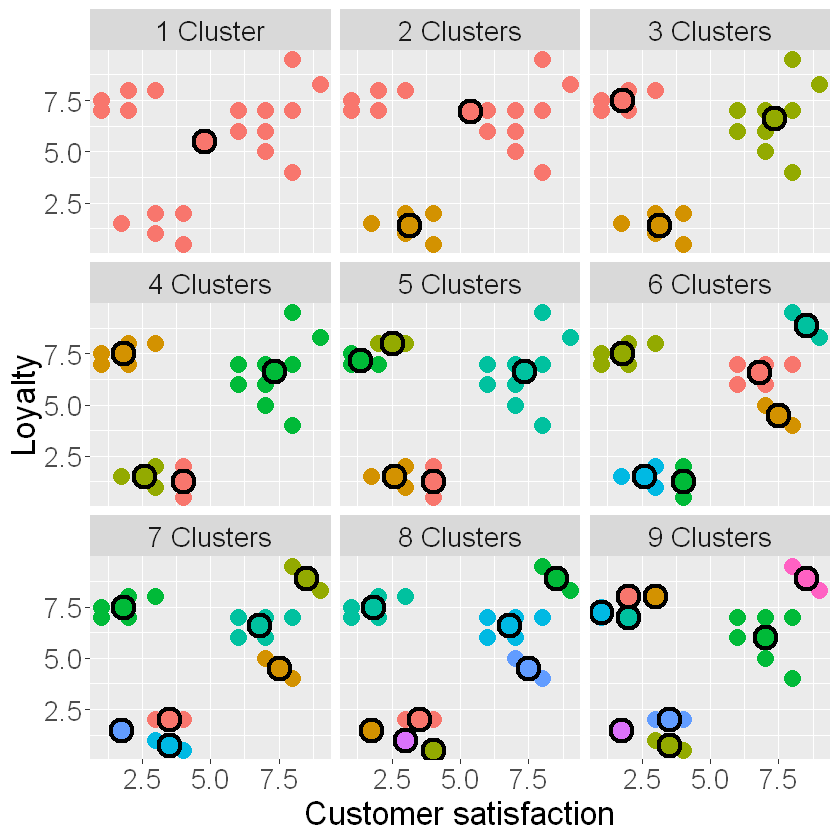

In [22]:
clusters$k <- factor(clusters$k)
levels(clusters$k) <- c("1 Cluster", "2 Clusters", "3 Clusters", "4 Clusters", "5 Clusters", "6 Clusters", "7 Clusters", "8 Clusters", "9 Clusters") 
p1 <- ggplot(assignments, aes(csat, loyalty)) +
  geom_point(aes(color = .cluster, size = 3)) + 
  facet_wrap(~ k) +
  labs(x = 'Customer satisfaction', y = 'Loyalty', colour = 'Cluster') +
  theme(text = element_text(size=20), legend.position = "none") +
  geom_point(data = clusters %>% mutate(y = loyalty, x = csat), aes(fill = cluster), colour = "black", size = 5, shape = 21, stroke = 2)
p1

If we set K less than 3, then the clustering merges separate groups of data; this causes a large 
total WSSD, since the cluster center (denoted by an "x") is not close to any of the data in the cluster. On 
the other hand, if we set K greater than 3, the clustering subdivides subgroups of data; this does indeed still 
decrease the total WSSD, but by only a *diminishing amount*. If we plot the total WSSD versus the number of 
clusters, we see that the decrease in total WSSD levels off (or forms an "elbow shape") when we reach roughly 
the right number of clusters.

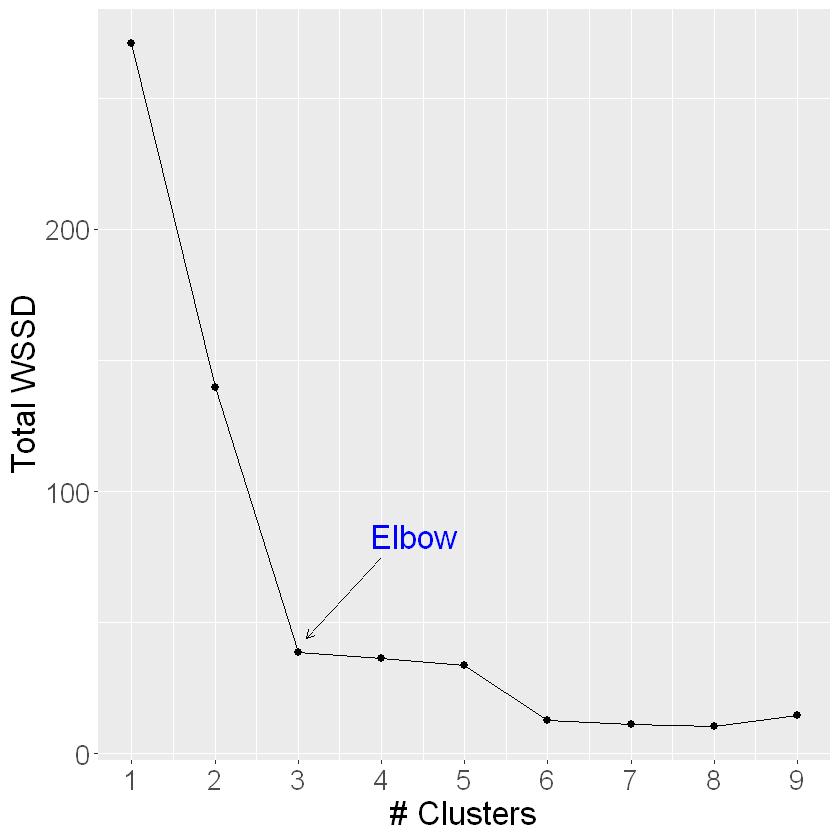

In [23]:
p2 <- ggplot(clusterings, aes(x = k, y = tot.withinss)) +
        geom_point(size = 2) +
        geom_line() +
        #annotate(geom = "line", x = 4, y = 35, xend = 2.65, yend = 27, arrow = arrow(length = unit(2, "mm"))) +
        geom_segment (aes (x = 4, y = 75, xend = 3.1, yend = 44), arrow = arrow (length = unit (0.2, "cm"))) +
        annotate("text", x = 4.4, y = 83, label="Elbow", size = 7, colour = "blue") +
        labs(x = "# Clusters", y = "Total WSSD") +
        theme(text = element_text(size=20)) + 
        scale_x_continuous(breaks = 1:9)
p2

## Data pre-processing for K-means

Similar to K-nearest neighbours classification and regression, K-means 
clustering uses straight-line distance to decide which points are similar to 
each other. Therefore, the *scale* of each of the variables in the data
will influence which cluster data points end up being assigned to.
Variables that have a large scale will have a much larger 
effect on deciding cluster assignment than variables with a small scale. 
To address this problem, we typically standardize our data before clustering,
which ensures that each variable has a mean of 0 and standard deviation of 1.
The `scale` function in R can be used to do this. 
We show an example of how to use this function 
below using the data in this chapter:

In [24]:
unscaled_data <- read_csv('marketing.csv') %>%
	mutate(cluster=as_factor(cluster)) %>% 
  select(loyalty, csat)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  loyalty = col_double(),
  csat = col_double(),
  cluster = col_double()
)



In [25]:
scaled_data <- map_df(unscaled_data, scale)
scaled_data

loyalty,csat
0.5409748,-1.4018879
0.7200432,-1.4018879
0.8991115,-1.0306562
0.5409748,-1.0306562
0.8991115,-0.6594246
-1.4287768,-1.1234642
-1.6078451,-0.6594246
-1.7869134,-0.2881930
-1.2497084,-0.2881930
0.5409748,0.4542703


## K-means in R

To peform K-means clustering in R, we use the `kmeans` function. It takes at
least two arguments: the data frame containing the data you wish to cluster,
and K, the number of clusters (here we choose K = 3). Note that since the K-means
algorithm uses a random initialization of assignments, we need to set the random
seed to make the clustering reproducible.

In [26]:
set.seed(1234)
marketing_clust <- kmeans(marketing_data, centers = 3)
marketing_clust

K-means clustering with 3 clusters of sizes 9, 5, 5

Cluster means:
   loyalty     csat    label
1 6.644444 7.333333 1.777778
2 7.500000 1.800000 3.000000
3 1.400000 3.150000 3.000000

Clustering vector:
 [1] 2 2 2 2 2 3 3 3 3 1 1 1 1 1 1 1 1 1 3

Within cluster sum of squares by cluster:
[1] 31.35778  3.80000  5.15000
 (between_SS / total_SS =  85.6 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

As you can see above, the clustering object returned by `kmeans` has a lot of information
that can be used to visualize the clusters, pick K, and evaluate the total WSSD.
To obtain this information in a tidy format, we will call in help 
from the `broom` package. Let's start by visualizing the clustering
as a coloured scatter plot. To do that
we use the `augment` function, which takes in the model and the original data
frame, and returns a data frame with the data and the cluster assignments for
each point:

In [27]:
clustered_data <- augment(marketing_clust, marketing_data)
clustered_data

loyalty,csat,label,.cluster
7.0,1.00,3,2
7.5,1.00,3,2
8.0,2.00,3,2
7.0,2.00,3,2
8.0,3.00,3,2
1.5,1.75,3,3
1.0,3.00,3,3
0.5,4.00,3,3
2.0,4.00,3,3
7.0,6.00,2,1


Now that we have this information in a tidy data frame, we can make a visualization
of the cluster assignments for each point:

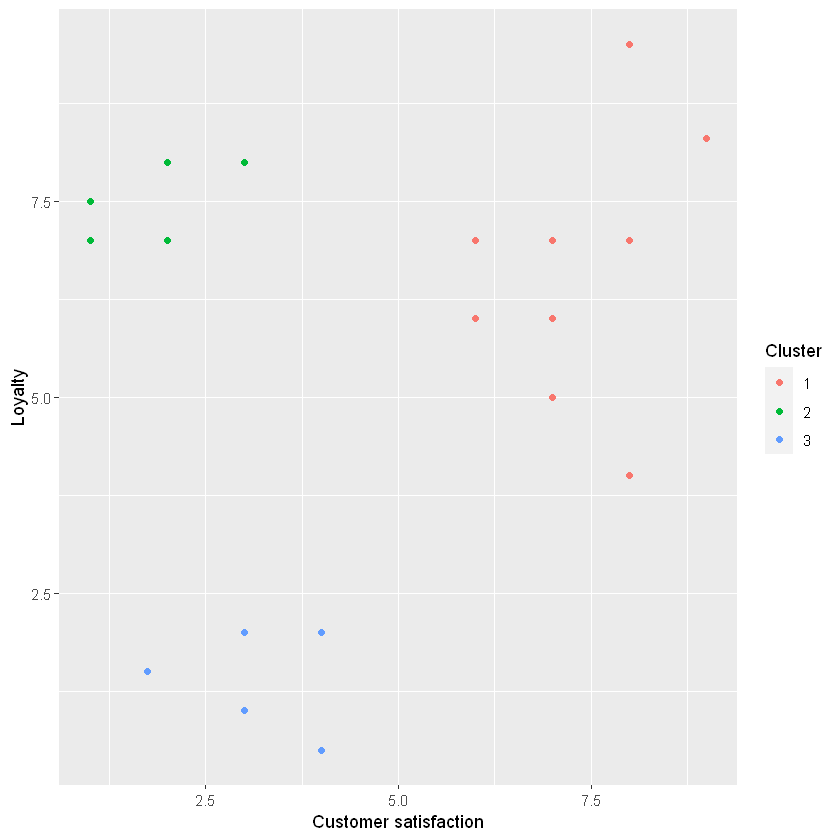

In [28]:
cluster_plot <- ggplot(clustered_data, 
                       aes(x = csat, y = loyalty, colour = .cluster), 
                       size=2) +
  geom_point() +
  labs(x = 'Customer satisfaction', y = 'Loyalty', colour = 'Cluster')
cluster_plot

As mentioned above, we also need to select K by finding
where the "elbow" occurs in the plot of total WSSD versus number of clusters. 
We can obtain the total WSSD (`tot.withinss`) from our
clustering using `broom`'s `glance` function. For example:

In [30]:
glance(marketing_clust)

totss,tot.withinss,betweenss,iter
279.5813,40.30778,239.2735,2


To calculate the total WSSD for a variety of Ks, we will
create a data frame with a column named `k` with rows containing
each value of K we want to run K-means with (here, 1 to 9). 

In [31]:
marketing_clust_ks <- tibble(k = 1:9) 
marketing_clust_ks

k
1
2
3
4
5
6
7
8
9


Then we use `map` to apply the `kmeans` function to each
K. However, we need to use `map` a little bit differently than we have
before. This is because we need to iterate over `k`, which is the *second argument* 
to the `kmeans` function. In the past, we have used `map` only to iterate over values of the
*first argument* of a function. Since that is the default, we could simply 
write `map(data_frame, function_name)`. This won't work here; we need to 
provide our data frame as the first argument to the `kmeans` function.

The solution is to create something called an *anonymous function*. 
An anonymous function is a function that has no name,
unlike other functions you've seen so far (`kmeans`, `select`, etc). 
To do this we will write our map statement like this:

In [32]:
map(marketing_clust_ks, function(k) kmeans(marketing_data, k))

ERROR: Error in kmeans(marketing_data, k): must have same number of columns in 'x' and 'centers'


Next, we use `map` again to apply `glance` to each of the K-means
clustering objects to get the clustering statistics (including WSSD). The output
of glance is a data frame, and so we get another list column. This results in a 
complex data frame with 3 columns, one for K, one for the 
K-means clustering objects, and one for the clustering statistics:

In [33]:
marketing_clust_ks <- tibble(k = 1:9) %>%
  mutate(marketing_clusts = map(k, ~kmeans(marketing_data, .x)),
         glanced = map(marketing_clusts, glance)) 
marketing_clust_ks

k,marketing_clusts,glanced
1,"1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 5.489474e+00, 4.776316e+00, 2.421053e+00, 2.795813e+02, 2.795813e+02, 2.795813e+02, -5.684342e-14, 1.900000e+01, 1.000000e+00","2.795813e+02, 2.795813e+02, -5.684342e-14, 1.000000e+00"
2,"2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 1.000000, 1.000000, 1.000000, 1.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 1.000000, 1.400000, 6.950000, 3.150000, 5.357143, 3.000000, 2.214286, 279.581316, 5.150000, 140.726429, 145.876429, 133.704887, 5.000000, 14.000000, 1.000000, 0.000000","279.5813, 145.8764, 133.7049, 1.0000"
3,"3.000000, 3.000000, 3.000000, 3.000000, 3.000000, 1.000000, 1.000000, 1.000000, 1.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 1.000000, 1.400000, 6.644444, 7.500000, 3.150000, 7.333333, 1.800000, 3.000000, 1.777778, 3.000000, 279.581316, 5.150000, 31.357778, 3.800000, 40.307778, 239.273538, 5.000000, 9.000000, 5.000000, 1.000000, 0.000000","279.58132, 40.30778, 239.27354, 1.00000"
4,"1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 3.000000, 2.000000, 2.000000, 2.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 2.000000, 7.500000, 1.375000, 1.500000, 6.644444, 1.800000, 3.500000, 1.750000, 7.333333, 3.000000, 3.000000, 3.000000, 1.777778, 279.581316, 3.800000, 2.687500, 0.000000, 31.357778, 37.845278, 241.736038, 5.000000, 4.000000, 1.000000, 9.000000, 1.000000, 0.000000","279.58132, 37.84528, 241.73604, 1.00000"
5,"3.0000000, 3.0000000, 5.0000000, 3.0000000, 5.0000000, 2.0000000, 2.0000000, 2.0000000, 2.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 4.0000000, 1.0000000, 4.0000000, 1.0000000, 2.0000000, 6.0000000, 1.4000000, 7.1666667, 8.9000000, 8.0000000, 7.0000000, 3.1500000, 1.3333333, 8.5000000, 2.5000000, 1.7142857, 3.0000000, 3.0000000, 2.0000000, 3.0000000, 279.5813158, 13.4285714, 5.1500000, 0.8333333, 1.2200000, 0.5000000, 21.1319048, 258.4494110, 7.0000000, 5.0000000, 3.0000000, 2.0000000, 2.0000000, 2.0000000, 0.0000000","279.5813, 21.1319, 258.4494, 2.0000"
6,"3.0000000, 3.0000000, 2.0000000, 3.0000000, 2.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 5.0000000, 5.0000000, 5.0000000, 5.0000000, 6.0000000, 4.0000000, 5.0000000, 4.0000000, 6.0000000, 1.0000000, 1.4000000, 8.0000000, 7.1666667, 8.9000000, 6.6000000, 4.5000000, 3.1500000, 2.5000000, 1.3333333, 8.5000000, 6.8000000, 7.5000000, 3.0000000, 3.0000000, 3.0000000, 2.0000000, 2.0000000, 1.0000000, 279.5813158, 5.1500000, 0.5000000, 0.8333333, 1.2200000, 4.0000000, 1.0000000, 12.7033333, 266.8779825, 5.0000000, 2.0000000, 3.0000000, 2.0000000, 5.0000000, 2.0000000, 2.0000000, 0.0000000","279.58132, 12.70333, 266.87798, 2.00000"
7,"2.0000, 2.0000, 1.0000, 6.0000, 1.0000, 4.0000, 4.0000, 4.0000, 4.0000, 7.0000, 7.0000, 7.0000, 7.0000, 5.0000, 3.0000, 7.0000, 3.0000, 5.0000, 4.0000, 8.0000, 7.2500, 8.9000, 1.4000, 4.5000, 7.0000, 6.6000, 2.5000, 1.0000, 8.5000, 3.1500, 7.5000, 2.0000, 6.8000, 3.0000, 3.0000, 2.0000, 3.0000, 1.0000, 3.0000, 2.0000, 279.5813, 0.5000, 0.1250, 1.2200, 5.1500, 1.0000, 0.0000, 4.0000, 11.9950, 267.5863, 2.0000, 2.0000, 2.0000, 5.0000, 2.0000, 1.0000, 5.0000, 2.0000, 0.0000","279.5813, 11.9950, 267.5863, 2.0000"
8,"7.000000, 7.000000, 1.000000, 3.000000, 8.000000, 2.000000, 2.000000, 4.000000, 4.000000, 6.000000, 6.000000, 6.000000, 6.000000, 6.000000, 5.000000, 6.000000, 5.000000, 6.000000, 2.000000, 8.000000, 1.500000, 7.000000, 1.250000, 8.900000, 6.000000, 7.250000, 8.000000, 2.000000, 2.583333, 2.000000, 4.000000, 8.500000, 7.000000, 1.000000, 3.000000, 3.000000, 3.000000, 3.000000, 3.000000, 2.000000, 1.714286, 3.000000, 3.000000, 279.581316, 0.0

Finally we extract the total WSSD from the `glanced` column. Given that each 
item in this column is a data frame, we will need to use the `unnest` function 
to unpack the data frames into simpler column data types. 

In [34]:
clustering_statistics <- marketing_clust_ks %>%
  unnest(glanced)
clustering_statistics

k,marketing_clusts,totss,tot.withinss,betweenss,iter
1,"1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 5.489474e+00, 4.776316e+00, 2.421053e+00, 2.795813e+02, 2.795813e+02, 2.795813e+02, -5.684342e-14, 1.900000e+01, 1.000000e+00",279.5813,279.581316,-5.684342e-14,1
2,"2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 1.000000, 1.000000, 1.000000, 1.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 1.000000, 1.400000, 6.950000, 3.150000, 5.357143, 3.000000, 2.214286, 279.581316, 5.150000, 140.726429, 145.876429, 133.704887, 5.000000, 14.000000, 1.000000, 0.000000",279.5813,145.876429,1.337049e+02,1
3,"3.000000, 3.000000, 3.000000, 3.000000, 3.000000, 1.000000, 1.000000, 1.000000, 1.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 2.000000, 1.000000, 1.400000, 6.644444, 7.500000, 3.150000, 7.333333, 1.800000, 3.000000, 1.777778, 3.000000, 279.581316, 5.150000, 31.357778, 3.800000, 40.307778, 239.273538, 5.000000, 9.000000, 5.000000, 1.000000, 0.000000",279.5813,40.307778,2.392735e+02,1
4,"1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 3.000000, 2.000000, 2.000000, 2.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 4.000000, 2.000000, 7.500000, 1.375000, 1.500000, 6.644444, 1.800000, 3.500000, 1.750000, 7.333333, 3.000000, 3.000000, 3.000000, 1.777778, 279.581316, 3.800000, 2.687500, 0.000000, 31.357778, 37.845278, 241.736038, 5.000000, 4.000000, 1.000000, 9.000000, 1.000000, 0.000000",279.5813,37.845278,2.417360e+02,1
5,"3.0000000, 3.0000000, 5.0000000, 3.0000000, 5.0000000, 2.0000000, 2.0000000, 2.0000000, 2.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 4.0000000, 1.0000000, 4.0000000, 1.0000000, 2.0000000, 6.0000000, 1.4000000, 7.1666667, 8.9000000, 8.0000000, 7.0000000, 3.1500000, 1.3333333, 8.5000000, 2.5000000, 1.7142857, 3.0000000, 3.0000000, 2.0000000, 3.0000000, 279.5813158, 13.4285714, 5.1500000, 0.8333333, 1.2200000, 0.5000000, 21.1319048, 258.4494110, 7.0000000, 5.0000000, 3.0000000, 2.0000000, 2.0000000, 2.0000000, 0.0000000",279.5813,21.131905,2.584494e+02,2
6,"3.0000000, 3.0000000, 2.0000000, 3.0000000, 2.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 5.0000000, 5.0000000, 5.0000000, 5.0000000, 6.0000000, 4.0000000, 5.0000000, 4.0000000, 6.0000000, 1.0000000, 1.4000000, 8.0000000, 7.1666667, 8.9000000, 6.6000000, 4.5000000, 3.1500000, 2.5000000, 1.3333333, 8.5000000, 6.8000000, 7.5000000, 3.0000000, 3.0000000, 3.0000000, 2.0000000, 2.0000000, 1.0000000, 279.5813158, 5.1500000, 0.5000000, 0.8333333, 1.2200000, 4.0000000, 1.0000000, 12.7033333, 266.8779825, 5.0000000, 2.0000000, 3.0000000, 2.0000000, 5.0000000, 2.0000000, 2.0000000, 0.0000000",279.5813,12.703333,2.668780e+02,2
7,"2.0000, 2.0000, 1.0000, 6.0000, 1.0000, 4.0000, 4.0000, 4.0000, 4.0000, 7.0000, 7.0000, 7.0000, 7.0000, 5.0000, 3.0000, 7.0000, 3.0000, 5.0000, 4.0000, 8.0000, 7.2500, 8.9000, 1.4000, 4.5000, 7.0000, 6.6000, 2.5000, 1.0000, 8.5000, 3.1500, 7.5000, 2.0000, 6.8000, 3.0000, 3.0000, 2.0000, 3.0000, 1.0000, 3.0000, 2.0000, 279.5813, 0.5000, 0.1250, 1.2200, 5.1500, 1.0000, 0.0000, 4.0000, 11.9950, 267.5863, 2.0000, 2.0000, 2.0000, 5.0000, 2.0000, 1.0000, 5.0000, 2.0000, 0.0000",279.5813,11.995000,2.675863e+02,2
8,"7.000000, 7.000000, 1.000000, 3.000000, 8.000000, 2.000000, 2.000000, 4.000000, 4.000000, 6.000000, 6.000000, 6.000000, 6.000000, 6.000000, 5.000000, 6.000000, 5.000000, 6.000000, 2.000000, 8.000000, 1.500000, 7.000000, 1.250000, 8.900000, 6.000000, 7.250000, 8.000000, 2.000000, 2.583333, 2.000000, 4.000000, 8.500000, 7.000000, 1.000000, 3.000000, 3.000000, 3.000000, 3.000000, 3.000000, 2.000000, 1.714286, 3.000000, 3.000000, 279.581316, 0.000000, 1.541667, 0.000000, 1.125

Now that we have `tot.withinss` and `k` as columns in a data frame, we can make a line plot 
and search for the "elbow" to find which value of K to use. 

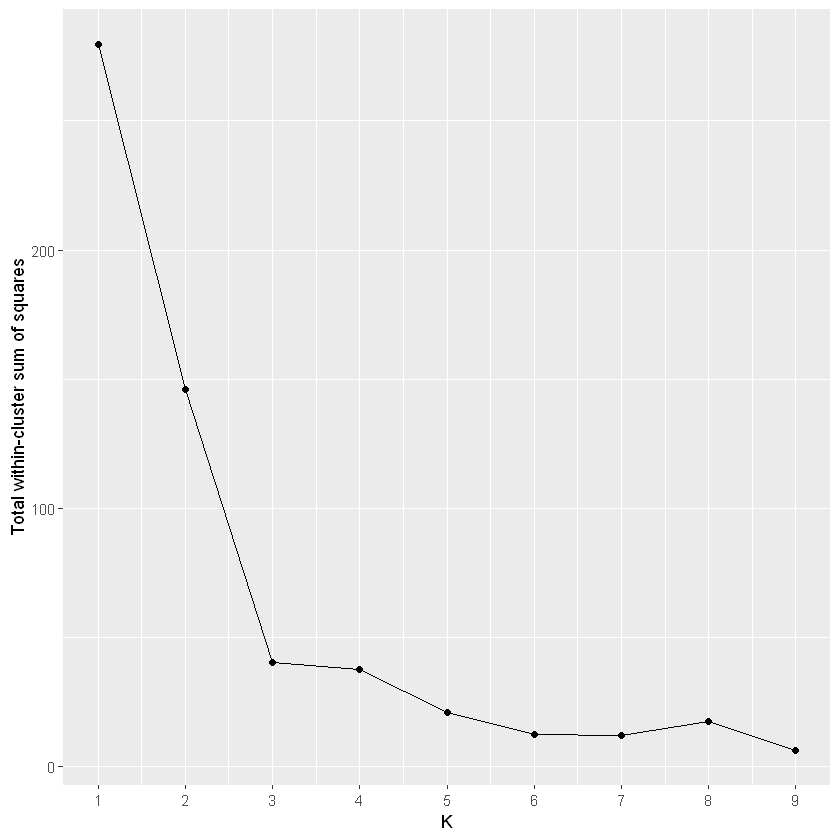

In [35]:
elbow_plot <- ggplot(clustering_statistics, aes(x = k, y = tot.withinss)) +
  geom_point() +
  geom_line() +
  xlab("K") +
  ylab("Total within-cluster sum of squares")+
  scale_x_continuous(breaks = 1:9)
elbow_plot

It looks like 3 clusters is the right choice for this data.
But why is there a "bump" in the total WSSD plot here? Shouldn't total WSSD always
decrease as we add more clusters? Technically yes, but remember:  K-means can 
get "stuck" in a bad solution. Unfortunately, for K = 6 we had an unlucky initialization
and found a bad clustering! We can help prevent finding a bad clustering by trying a 
few different random initializations via the `nstart` argument (here we use 10 restarts). 

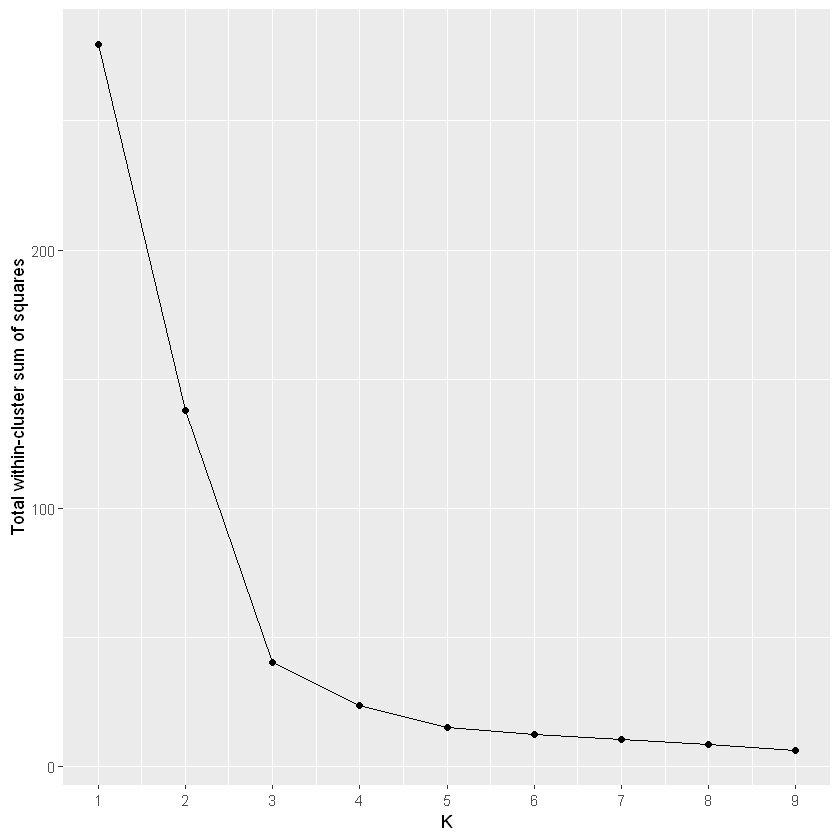

In [36]:
marketing_clust_ks <- tibble(k = 1:9) %>%
  mutate(marketing_clusts = map(k, ~kmeans(marketing_data, nstart = 10, .x)),
         glanced = map(marketing_clusts, glance)) 
clustering_statistics <- marketing_clust_ks %>%
  unnest(glanced)
elbow_plot <- ggplot(clustering_statistics, aes(x = k, y = tot.withinss)) +
  geom_point() +
  geom_line() +
  xlab("K") +
  ylab("Total within-cluster sum of squares")+
  scale_x_continuous(breaks = 1:9)
elbow_plot

## Additional resources

For more about clustering and K-means, refer to pages 385-390 and 404-405 
of [Introduction to Statistical Learning with Applications in R](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) [-@james2013introduction]. We have also linked a helpful companion video below:
https://www.youtube.com/embed/aIybuNt9ps4
